In [2]:
from ecell4 import *
import math
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
rng = GSLRandomNumberGenerator()

In [22]:
voxelr = 0.005
simrun = 1#000
L = 1.#0.15
V = L**3
Da = 10.
Db = 0.
Lr = 0.15 #length used in spatiocyte
conc = 1./(Lr**3)
Na = int(V*conc)
T = np.logspace(-5,0,100)
print 'Na',Na
kD = 4*3.14*2*voxelr*Da
ka = 10.*kD
kon = ka*kD/(ka+kD)
print kD,ka,kon
dt = 2*voxelr*voxelr/3./Da
tb = (0.5*0.5*L*L)/6./Da #time to boundary
print 'dt',dt,tb,tb/dt
pacc = ka/6./(2**0.5)/Da/voxelr
print 'pacc',pacc,dt/pacc
print L/voxelr

Na 296
1.256 12.56 1.14181818182
dt 1.66666666667e-06 0.00416666666667 2500.0
pacc 29.6042039057 5.6298310604e-08
200.0


In [23]:
def create_model_gil(Da,Db,k): 
    with species_attributes():
        A | {'D': str(Da)}
        B | {'D': str(Db)}
    with reaction_rules():
        A + B > B | k
    return get_model()

# kon / (0.15 ** 3)
# kon * 2370 * 1 / (2 ** 3)

def create_model_spa(Da,Db,k): 
    with species_attributes():
        A | {'D': str(Da),'radius': str(voxelr)}
        B | {'D': str(Db),'radius': str(voxelr)}
    with reaction_rules():
        A + B > B | k
    return get_model()

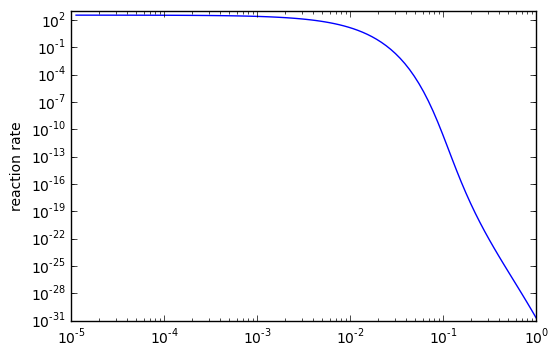

In [24]:
def run_gil(kon):
    m = create_model_gil(Da,Db,kon / (Lr ** 3) * V)
    Nt = ensemble_simulations(simrun,T, model=m,y0={'A':Na,'B':1}, solver='gillespie',volume=V,return_type='observer')
    time = Nt.data()[:,0]
    St = Nt.data()[:,1]/Na * escapeprob
    Rt = -(St[1:]-St[:-1])/(time[1:]-time[:-1])
    return time,Rt

def run_ode(kon):
    m = create_model_gil(Da,Db,kon / (Lr ** 3) * V)
    Nt = ensemble_simulations(simrun,T, model=m,y0={'A':Na,'B':1}, solver='ode',volume=V,return_type='observer')
    time = Nt.data()[:,0]
    St = Nt.data()[:,1]/Na * escapeprob
    Rt = -(St[1:]-St[:-1])/(time[1:]-time[:-1])
    return time,Rt

escapeprob = 1.#0.061#0.095
#t,Rt = run_gil(kon)
t2,Rt2 = run_ode(kon)
#plt.loglog(t[1:],Rt,'.')
plt.loglog(t2[1:],Rt2,'-')
plt.ylabel('reaction rate')

In [12]:
def run_spa(ka):
    m = create_model_spa(Da,Db,ka)
    Nt = ensemble_simulations(simrun,duration, model=m,y0={'A':Na,'B':1}, solver=('spatiocyte',voxelr),volume=V,return_type='observer')
    #Nt = ensemble_simulations(simrun,duration, model=m,y0={'A':Na,'B':1}, solver=('meso',Integer3(K,K,K)),volume=V,return_type='observer')
    time = Nt.data()[:,0]
    Nat = Nt.data()[:,1]/Na
    dS = -(Nat[1:]-Nat[:-1])/(time[1:]-time[:-1])
    plt.loglog(time[1:],dS,'.',label=kon)
    plt.legend()

15.0